# All Ireland Mbovis strain diversity

Run all samples together

In [125]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
sys.path.append('pathogenie')
from snpgenie import tools, aligners, app, trees, plotting

## run NI first

In [ ]:
reload(app)
args = {'threads':20, 'outdir': '/storage/btbgenie/NI_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/NI'],
         'reference': None, 'overwrite':False,
         'custom_filters': True,
         'mask': app.mbovis_mask,        
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## custom code to integrate previously aligned bam files together and call variants

This allows us to join separate datasets together in one call without re-aligning

In [7]:
#read in bam files
mapped_paths = ['/storage/btbgenie/wicklow_results/mapped/','/storage/btbgenie/monaghan/monaghan_results/mapped/',
               '/storage/btbgenie/NI_results/']
reload(app)
bam_files=[]
for m in mapped_paths:
    f=app.get_files_from_paths(m, '*.bam')
    bam_files.extend(f)
print (len(bam_files))

outdir='/storage/btbgenie/all_ireland_results'
df = app.get_samples(bam_files,sep='_')
app.write_samples(df, outdir)

249


,name,sample,filename,pair
0,31-12952,31-12952,/storage/btbgenie/wicklow_results/mapped/31-12...,1
1,48-MBovis,48-MBovis,/storage/btbgenie/wicklow_results/mapped/48-MB...,1
2,49-MBovis,49-MBovis,/storage/btbgenie/wicklow_results/mapped/49-MB...,1
3,28-12935,28-12935,/storage/btbgenie/wicklow_results/mapped/28-12...,1
4,27-MBovis,27-MBovis,/storage/btbgenie/wicklow_results/mapped/27-MB...,1
...,...,...,...,...
244,ERR125619,ERR125619,/storage/btbgenie/NI_results/mapped/ERR125619.bam,1
245,ERR125627,ERR125627,/storage/btbgenie/NI_results/mapped/ERR125627.bam,1
246,ERR125624,ERR125624,/storage/btbgenie/NI_results/mapped/ERR125624.bam,1
247,ERR125609,ERR125609,/storage/btbgenie/NI_results/mapped/ERR125609.bam,1


In [8]:
#df.to_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv',index=False)

In [ ]:
vcf_file = app.variant_calling(bam_files, app.mbovis_genome, outdir, threads=20,                               
                                mask=app.mbovis_mask,
                                custom_filters=True, overwrite=False)
snprecs, smat = tools.fasta_alignment_from_vcf(vcf_file, omit=['161-MBovis'])
outfasta = os.path.join(outdir, 'core.fa')
SeqIO.write(snprecs, outfasta, 'fasta')
smat.to_csv(os.path.join(outdir,'core.txt'), sep=' ')

In [70]:
vdf = tools.vcf_to_dataframe(vcf_file)

In [14]:
reload(tools)
#snprecs, smat = tools.fasta_alignment_from_vcf(vcf_file, omit=['161-MBovis'])

found 1983 sites
38 sites with at least one missing sample


In [16]:
treefile = trees.run_RAXML(outfasta, bootstraps=100, outpath=outdir, threads=12)

raxmlHPC-PTHREADS -f a -N 100 -T 12 -m GTRCAT -V -p 28698902 -x 25313430 -n variants -w /storage/btbgenie/all_ireland_results -s /storage/btbgenie/all_ireland_results/core.fa


In [22]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')

In [ ]:
reload(trees)
labelmap = dict(zip(meta['name'],meta.county))
colormap = trees.colors_from_labels(meta,'name','county')

t,ts = trees.create_tree('/storage/btbgenie/all_ireland_results/RAxML_bipartitions.variants', 'ref', colormap=colormap)
ts.scale=8000
#N = t.search_nodes(name="ref")[0]
#N.delete()

from ete3 import CircleFace, TreeStyle, NodeStyle, RectFace, TextFace
colors = {'wicklow': 'blue', 'monaghan': 'green','NI':'crimson'}
for i in colors:
    f=ts.legend.add_face(
            TextFace(text=i,fgcolor=colors[i],fsize=28),            
            column=0)
t.render("%%inline",tree_style=ts,w=800)

In [170]:
out = t.get_common_ancestor("19-4281", "19-2438")
out.delete()

In [171]:
wick = t.get_common_ancestor("19-11957", "43-MBovis")
mon = t.get_common_ancestor("19-7433", "19-6796")
mon2 = t.get_common_ancestor("548", "4960")
ni = t.get_common_ancestor("ERR125607","ERR125601")

In [172]:
colors=['LightSteelBlue','lightgreen','springgreen','salmon']
for common,clr in zip([wick,mon,mon2,ni],colors):
    nodesinbranch = [node for node in common.traverse()]
    nstyle1=NodeStyle()
    nstyle1['bgcolor']=clr
    common.set_style(nstyle1)

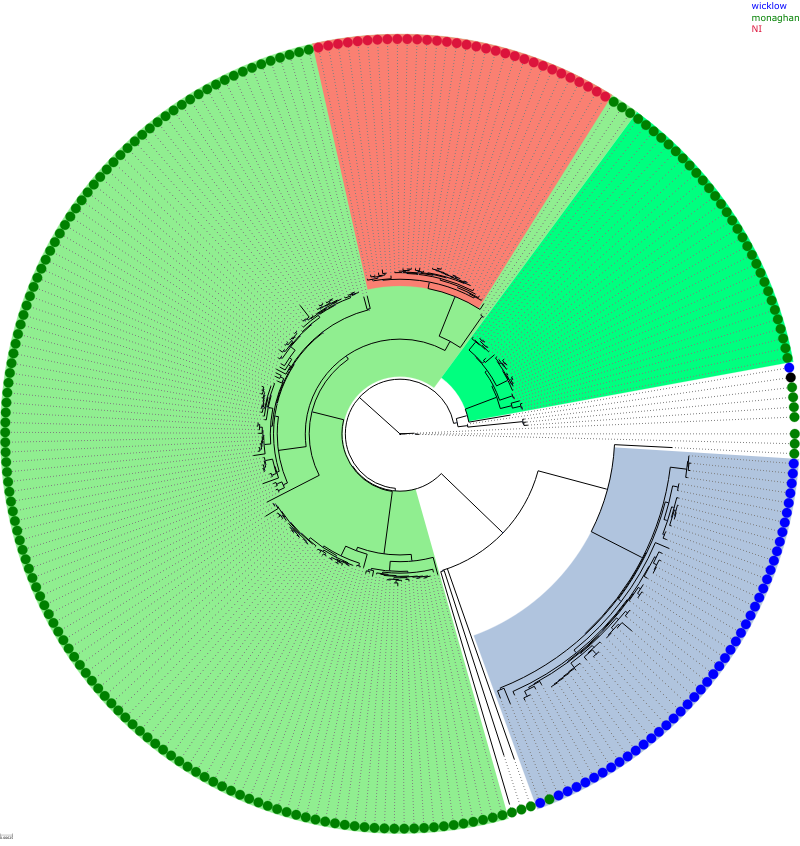

In [175]:
reload(trees)
trees.remove_tiplabels(t)
trees.set_nodesize(t, 40)
ts.mode = 'c'
t.render("%%inline",tree_style=ts,w=800)
#t.render("/storage/btbgenie/all_ireland.png",tree_style=ts,w=2000)